In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm

In [2]:
def plot_data(fil, avg = None, raw = False, fit = None):
    '''Plots the mean time trace of all Pixel of a given file base name.
    'raw' can be used to plot the raw counts of meas and ctrl, otherwise
    the michelson contrast is given. If avg is given, only the first avg
    frames will be used in the analysis. Two different fitting models can be used:
    'cos_epx_dec' and 'exp_dec'. '''
    if avg == None:
        avg = int(fil.split('_')[-1].strip('x'))
    first_npz_file = np.load(fil+'_frames_01.npz')
    n_points = (first_npz_file['frames_meas'].shape)[0]
    all_meas_mean = np.zeros((avg,n_points))
    all_ctrl_mean = np.zeros((avg,n_points))

    x_arr = get_x_axis(fil)

    for i in range(avg):
        npz_file = np.load(fil+'_frames_'+str(i+1).zfill(2)+'.npz')
        all_meas_mean[i] = np.mean(npz_file['frames_meas'], axis = (1,2))
        all_ctrl_mean[i] = np.mean(npz_file['frames_ctrl'], axis = (1,2))
    meas_mean = np.mean(all_meas_mean, axis = 0)
    ctrl_mean = np.mean(all_ctrl_mean, axis = 0)

    # For zooming in:
    #x_arr = x_arr[:100]
    #meas_mean = meas_mean[:100]
    #ctrl_mean = ctrl_mean[:100]

    fig,ax = plt.subplots()
    if raw:    
        ax.plot(x_arr, meas_mean)
        ax.plot(x_arr, ctrl_mean)
    else:
        ax.plot(x_arr, (meas_mean - ctrl_mean)/(meas_mean + ctrl_mean))
        if fit == 'exp_dec':
            fit_data, fit_params, fit_params_error = fit_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr)
            ax.plot(x_arr, fit_data, label = '$\gamma\' = {:.3f} +- {:.3f}$'.format(fit_params, fit_params_error))
            ax.legend()
            print(fit_params)
        elif fit == 'cos_exp_dec':
            fit_data, fit_params, fit_params_error = fit_cos_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr)
            # ax.plot(x_arr, fit_data, label = '$\gamma\' = {:.3f} +- {:.3f}$'.format(fit_params, fit_params_error))
            ax.plot(x_arr, fit_data, label = '$\period\' = {:.3f} +- {:.3f}$'.format(fit_params, fit_params_error))
            ax.legend()
            print(fit_params)
        elif fit == 'mult_cos_exp_dec':
            fit_data, fit_params, fit_params_error = fit_mult_cos_exp((meas_mean-ctrl_mean)/(meas_mean + ctrl_mean), x_arr)
            ax.plot(x_arr, fit_data, label = '$\gamma\' = {:.3f} +- {:.3f}$'.format(fit_params, fit_params_error))
            ax.legend()
            print(fit_params)
    ax.set_xlabel('tau [ns]')
    plt.show()
    
def plot_data_single_pixel(fil, pixels = None, avg = None, raw = False, fit = None):
    '''Plots the time trace of a single pixel of a given file base name.
    'raw' can be used to plot the raw counts of meas and ctrl, otherwise
    the michelson contrast is given. If avg is given, only the first avg
    frames will be used in the analysis. If more than one pixel is given,
    all will be plotted in the same plot and als normalized (to compare 
    the lineshape)'''
    if avg == None:
        avg = int(fil.split('_')[-1].strip('x'))    # get number of avergaes from file name
    first_npz_file = np.load(fil+'_frames_01.npz')
    shape = first_npz_file['frames_meas'].shape     # get number of x-values
    n_points = shape[0]
    if pixels == None:
        pixels = [(shape[1]//2, shape[2]//2)]  # take middle pixel
    x_arr = get_x_axis(fil)
    fig,ax = plt.subplots()
    for pixel in pixels:
        all_meas_mean = np.zeros((avg,n_points))
        all_ctrl_mean = np.zeros((avg,n_points))
        for i in range(avg):
            npz_file = np.load(fil+'_frames_'+str(i+1).zfill(2)+'.npz')
            all_meas_mean[i] = npz_file['frames_meas'][:,pixel[0], pixel[1]]
            all_ctrl_mean[i] = npz_file['frames_ctrl'][:, pixel[0], pixel[1]]
        meas_mean = np.mean(all_meas_mean, axis = 0)
        ctrl_mean = np.mean(all_ctrl_mean, axis = 0)
        if len(pixels) > 1:
            meas_mean /= max(meas_mean)
            ctrl_mean /= max(ctrl_mean)
        if raw:    
            ax.plot(x_arr, meas_mean)
            ax.plot(x_arr, ctrl_mean)
        else:
            ax.plot(x_arr, (meas_mean - ctrl_mean)/(meas_mean + ctrl_mean))
    ax.set_xlabel('tau [ns]')
    plt.show()

def get_x_axis(fil):    # get tau array from .pys file of measurement
    f = np.load(fil + '.pys', allow_pickle = True, encoding='latin1')
    return f['tau']

def exp_dec(x, amp, gamma, offset):
    return amp * np.exp(-x/gamma) + offset

def cos_exp_dec(x, amp, gamma, offset, phase, period):
    return amp * np.exp(-x/gamma)*np.cos(2*np.pi/period*x + phase) + offset

def mult_cos_exp_dec(x, gamma, offset, amp, period1, phase1, period2, phase2):
    return np.exp(-x/gamma)*amp*np.cos(2*np.pi/period1*x + phase1)*np.cos(2*np.pi/period2*x + phase2) + offset

def fit_exp(trace, x_arr):
    model = lm.Model(exp_dec)
    params_model = model.make_params(amp = 0.07, offset = -0.07, gamma = 10)
    fit_res = model.fit(trace, params_model, x = x_arr)
    fittrace = model.eval(fit_res.params, x = x_arr)
    #print(fit_res.fit_report())
    return fittrace, fit_res.params['gamma'].value, fit_res.params['gamma'].stderr

def fit_cos_exp(trace, x_arr):
    model = lm.Model(cos_exp_dec)
    params_model = model.make_params(amp = 0.07, offset = -0.07, gamma = 10, period = 50, phase = 0)
    fit_res = model.fit(trace, params_model, x = x_arr)
    fittrace = model.eval(fit_res.params, x = x_arr)
    print(fit_res.fit_report())
    # return fittrace, fit_res.params['gamma'].value, fit_res.params['gamma'].stderr
    return fittrace, fit_res.params['period'].value, fit_res.params['period'].stderr

def fit_mult_cos_exp(trace, x_arr):
    model = lm.Model(mult_cos_exp_dec)
    params = lm.Parameters()
    #params.add_many(('amp', 0.07), ('offset', -0.07), ('gamma', 10), ('period1', 50, True, 0), ('phase1', 0, True,0), ('period2', 60, True,0), ('phase2', 0.1, True,0))
    params_model = model.make_params(amp = 0.07, offset = -0.07, gamma = 10, period1 = 50, phase1 = 0, period2 = 60, phase2 = 0.1)
    fit_res = model.fit(trace, params_model, x = x_arr)
    #fit_res = model.fit(trace, params, x = x_arr)
    fittrace = model.eval(fit_res.params, x = x_arr)
    print(fit_res.fit_report())
    return fittrace, fit_res.params['gamma'].value, fit_res.params['gamma'].stderr

def fit_all_pixel(mean_data):
    print(mean_data.shape)
    n_tau, n_x, n_y = mean_data.shape
    gammas = np.zeros((n_x, n_y))
    fit_data = np.zeros_like(mean_data)
    for x in range(n_x):
        for y in range(n_y):
            fit_data[:,x,y], gammas[x,y], _ = fit_exp(mean_data[:,x,y])           
            #plt.plot(fit_data[:,x,y])
            #plt.show()
    return fit_data, gammas

def plot_2D_gamma(fil, avg = None):
    if avg == None:
        avg = int(fil.split('_')[-1].strip('x'))
    first_npz_file = np.load(fil+'_frames_01.npz')
    n_points, nx, ny = (first_npz_file['frames_meas'].shape)
    all_meas = np.zeros((avg,n_points, nx, ny))
    all_ctrl = np.zeros((avg,n_points, nx, ny))

    for i in range(avg):
        npz_file = np.load(fil+'_frames_'+str(i+1).zfill(2)+'.npz')
        all_meas[i] = npz_file['frames_meas']
        all_ctrl[i] = npz_file['frames_ctrl']
    meas_mean = np.mean(all_meas, axis = 0)
    ctrl_mean = np.mean(all_ctrl, axis = 0)

    all_fit_data, all_gammas = fit_all_pixel((meas_mean - ctrl_mean)/(meas_mean + ctrl_mean))
    plt.imshow(all_gammas)
    plt.colorbar()
    plt.show()




In [7]:
#plot_data(r'data\013_Rabi_X_2.8704GHz_0.0dBm_6x', raw = True)
#plot_data(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x', raw = False, fit = 'exp_dec')
#plot_data(r'data\073 Rabi_AWG_2.8710GHz_-5.0dBm_10x', raw = False, fit = 'exp_dec')
#plot_data(r'data\075 Rabi_AWG_2.8710GHz_-10.0dBm_5x', fit = True)
#plot_data_single_pixel(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x', raw = False, pixels = [(0,0)])
#plot_data_single_pixel(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x', raw = False, pixels = [(19,19)])
#plot_2D_gamma(r'data\071 Rabi_AWG_2.8710GHz_0.0dBm_50x')
#plot_2D_gamma(r'data\075 Rabi_AWG_2.8710GHz_-10.0dBm_5x')
#plot_data(r'data\084 Rabi_AWG_2.8240GHz_-5.0dBm_1x', raw = True)
#plot_data_single_pixel(r'data\084 Rabi_AWG_2.8240GHz_-5.0dBm_1x', raw = True, pixels = [(0,0),(10,0),(0,10),(5,5)])
#plot_data(r'data\085 Rabi_AWG_2.8240GHz_-5.0dBm_1x', raw = True)
#plot_data(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = False, fit = 'exp_dec')
#plot_data(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = False, fit = 'cos_exp_dec')
#plot_data(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = False, fit = 'mult_cos_exp_dec')
#plot_data_single_pixel(r'data\086 Rabi_AWG_2.8240GHz_-5.0dBm_10x', raw = True,  pixels = [(0,0),(10,0),(0,10),(5,5)])

[[Model]]
    Model(cos_exp_dec)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # data points      = 100
    # variables        = 5
    chi-square         = 1.5323e-04
    reduced chi-square = 1.6129e-06
    Akaike info crit   = -1328.87623
    Bayesian info crit = -1315.85038
[[Variables]]
    amp:     0.01200167 +/- 8.3644e-04 (6.97%) (init = 0.07)
    gamma:   54.8368120 +/- 4.62946299 (8.44%) (init = 10)
    offset: -0.00928019 +/- 1.4547e-04 (1.57%) (init = -0.07)
    phase:   0.33928981 +/- 0.08101490 (23.88%) (init = 0)
    period:  125.789628 +/- 4.81276097 (3.83%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(phase, period)  = 0.833
    C(amp, gamma)     = -0.705
    C(amp, phase)     = 0.611
    C(amp, period)    = 0.502
    C(offset, phase)  = 0.413
    C(gamma, phase)   = -0.351
    C(offset, period) = 0.297
    C(gamma, period)  = -0.279
    C(amp, offset)    = 0.116
54.83681200665427


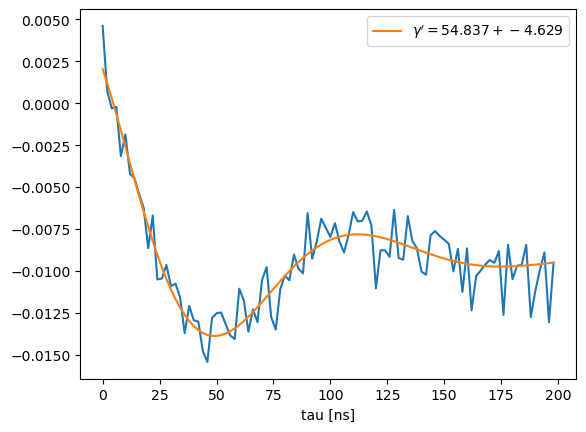

In [11]:
plot_data(r'data\034 Rabi_AWG_2.7100GHz_-2.0dBm_10x', raw = False, fit = 'cos_exp_dec')